# Data Exploration

In [1]:
#Importing the necessary packages
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import math
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf



from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from pmdarima.arima import ADFTest

In [2]:
#Impoprting the data
riv_stock_df = pd.read_csv('data/RIVN.csv', index_col = ['Date'], parse_dates=['Date'])
riv_stock_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-11-10,106.750000,119.459999,95.199997,100.730003,100.730003,103679500
2021-11-11,114.625000,125.000000,108.010002,122.989998,122.989998,83668200
2021-11-12,128.645004,135.199997,125.250000,129.949997,129.949997,50636800
2021-11-15,130.800003,152.529999,127.510002,149.360001,149.360001,64982300
2021-11-16,163.800003,179.470001,153.779999,172.009995,172.009995,94036600


In [3]:
#Checking the information
riv_stock_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 241 entries, 2021-11-10 to 2022-10-25
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       241 non-null    float64
 1   High       241 non-null    float64
 2   Low        241 non-null    float64
 3   Close      241 non-null    float64
 4   Adj Close  241 non-null    float64
 5   Volume     241 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 13.2 KB


In [4]:
#Converting date format to datetime for future plotting and calculations
riv_df = riv_stock_df

In [5]:
#Checking information
riv_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-11-10,106.750000,119.459999,95.199997,100.730003,100.730003,103679500
2021-11-11,114.625000,125.000000,108.010002,122.989998,122.989998,83668200
2021-11-12,128.645004,135.199997,125.250000,129.949997,129.949997,50636800
2021-11-15,130.800003,152.529999,127.510002,149.360001,149.360001,64982300
2021-11-16,163.800003,179.470001,153.779999,172.009995,172.009995,94036600


In [6]:
#Checking for any missing values
riv_df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [7]:
riv_df.index[0].month

11

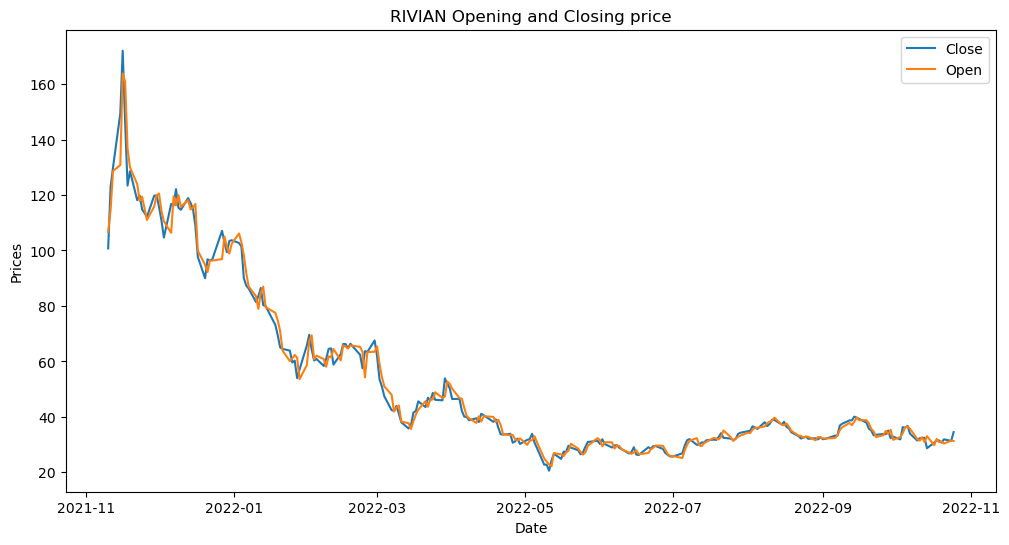

In [8]:
#Plotting the opening and closing price
plt.figure(figsize=(12,6))
plt.xlabel('Date')
plt.ylabel('Prices')
plt.plot(riv_df['Close'])
plt.plot(riv_df['Open'])
plt.title('RIVIAN Opening and Closing price')
plt.legend(['Close', 'Open'])
plt.show()

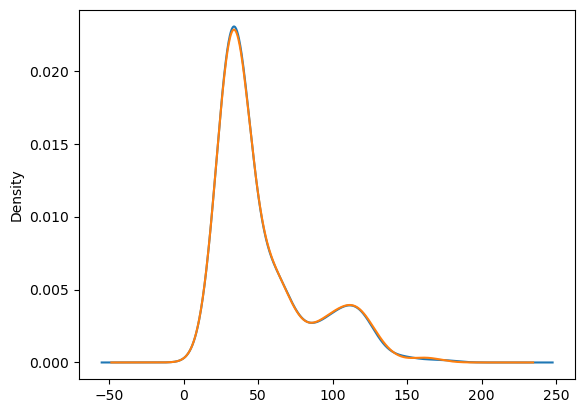

In [9]:
#Checking distribution of the dataset
riv_df_close = riv_df['Close']
riv_df_open = riv_df['Open']
riv_df_close.plot(kind='kde')
riv_df_open.plot(kind='kde');

In [10]:
#https://www.codingfinance.com/post/2018-04-03-calc-returns-py/
#Calculating daily and monthly return
riv_daily_return = pd.DataFrame(riv_df['Adj Close'].pct_change())
riv_monthly_return=pd.DataFrame(riv_df['Adj Close'].resample('M').ffill().pct_change())

In [11]:
#Chceking output
riv_daily_return

,Adj Close
Date,
2021-11-10,NaN
2021-11-11,0.220987
2021-11-12,0.056590
2021-11-15,0.149365
2021-11-16,0.151647
...,...
2022-10-19,-0.004425
2022-10-20,-0.024444
2022-10-21,0.038724


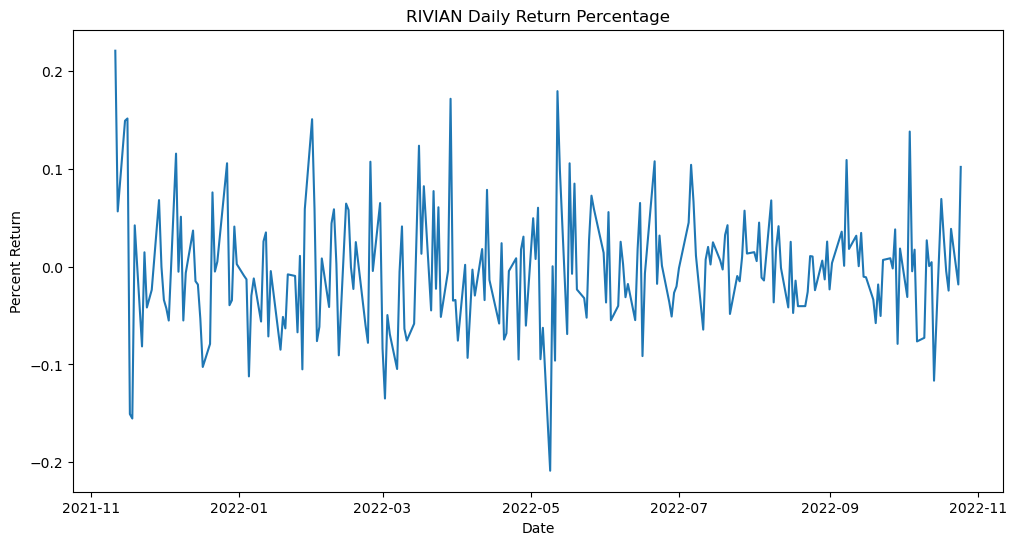

In [12]:
#Visualizing daily return
plt.figure(figsize=(12,6))
plt.xlabel('Date')
plt.ylabel('Percent Return')
plt.plot(riv_daily_return)
plt.title('RIVIAN Daily Return Percentage')
plt.show()

In [13]:
#Checking output
riv_monthly_return

,Adj Close
Date,
2021-11-30,NaN
2021-12-31,-0.134185
2022-01-31,-0.365995
2022-02-28,0.027685
2022-03-31,-0.256365
2022-04-30,-0.398089
2022-05-31,0.038360
2022-06-30,-0.180255
2022-07-31,0.332556


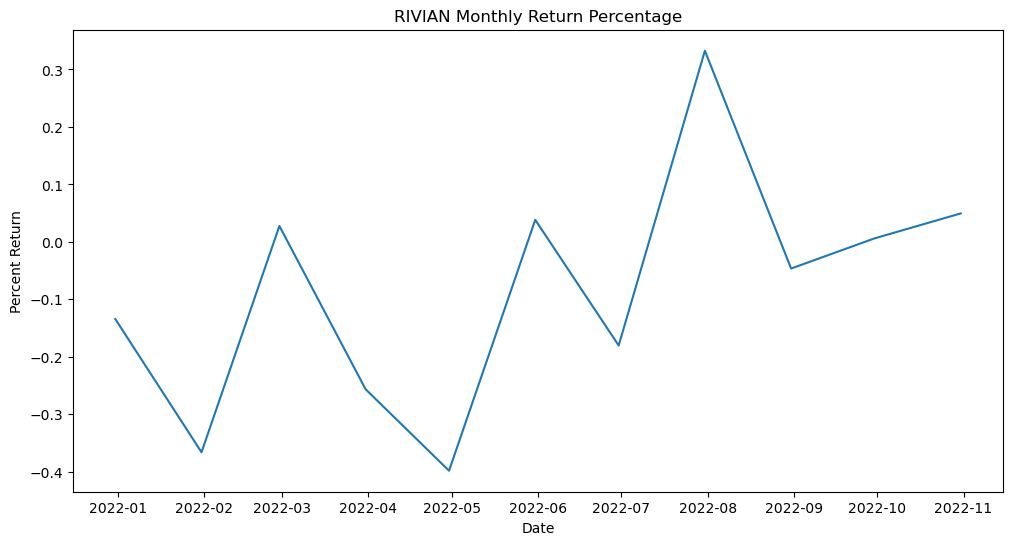

In [14]:
#Visualizing monthly return
plt.figure(figsize=(12,6))
plt.xlabel('Date')
plt.ylabel('Percent Return')
plt.plot(riv_monthly_return)
plt.title('RIVIAN Monthly Return Percentage')
plt.show()

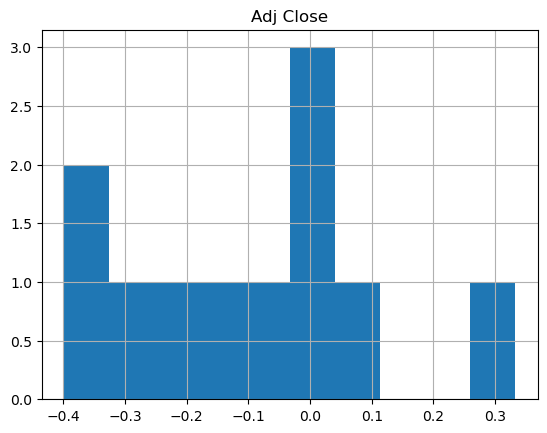

In [15]:
riv_monthly_return.hist();

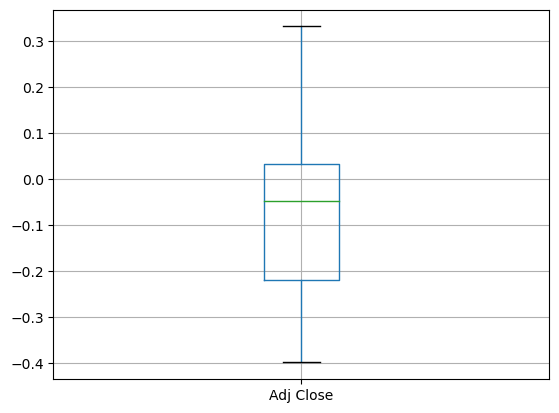

In [16]:
riv_monthly_return.boxplot();

In [17]:
# https://blog.devgenius.io/how-to-calculate-the-daily-returns-and-volatility-of-a-stock-with-python-d4e1de53e53b
#Calculating Volatility
daily_volatility_rivn = riv_daily_return['Adj Close'].std()
print('Daily volatility: \n --------------')
print('Rivian: ', '{:.2f}%'.format(daily_volatility_rivn))
print('\n')
monthly_volatility_rivn = math.sqrt(21) * daily_volatility_rivn
print('Monthly volatility: \n --------------')
print ('Rivian: ', '{:.2f}%'.format(monthly_volatility_rivn))
print('\n')
annual_volatility_rivn = math.sqrt(252) * daily_volatility_rivn
print('Annual volatility: \n --------------')
print ('Rivian: ', '{:.2f}%'.format(annual_volatility_rivn ))

Daily volatility: 
 --------------
Rivian:  0.06%


Monthly volatility: 
 --------------
Rivian:  0.28%


Annual volatility: 
 --------------
Rivian:  0.97%


# Model Preparation

In [18]:
# Creating function for assessment
def test_trend(ts_df):
    #Getting rolling statistics
    roll_mean = ts_df.rolling(11).mean()
    roll_std = ts_df.rolling(11).std()
    #Plotting rolling statistics
    fig = plt.figure(figsize=(12,7))
    plt.plot(ts_df, color='blue', label='Original')
    plt.plot(roll_mean, color='red', label='Rolling Mean')
    plt.plot(roll_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    print("Results of the Dickey-Fuller Test")
    dftest = adfuller(ts_df)
    # Output for dickey-fuller test will give us the values without defining what the values are.
    # Manually writing the values
    dfoutput = pd.Series(dftest[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in dftest[4].items():
        dfoutput['critical value (%s)'%key] =  values
    print(dfoutput)
    print('\n\n')
    print("Results of KPSS Test:")
    kpsstest = kpss(ts_df, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

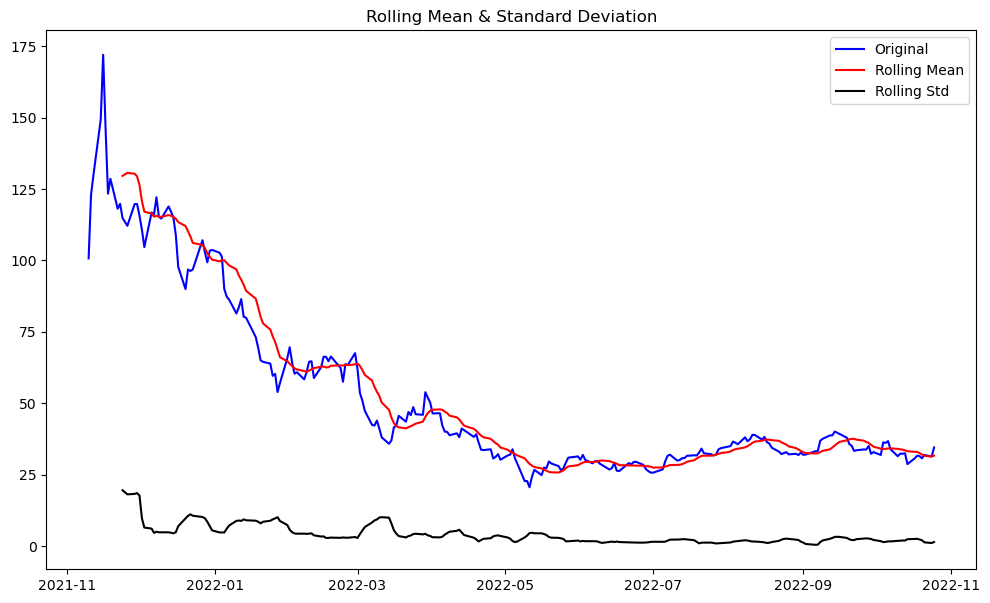

Results of the Dickey-Fuller Test
Test Statistics                 -3.210784
p-value                          0.019369
No. of lags used                 8.000000
Number of observations used    232.000000
critical value (1%)             -3.458855
critical value (5%)             -2.874080
critical value (10%)            -2.573453
dtype: float64



Results of KPSS Test:
Test Statistic            1.657514
p-value                   0.010000
Lags Used                10.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


C:\Users\Jonathan\anaconda3\envs\time-series-env\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


In [19]:
test_trend(riv_df['Close'])

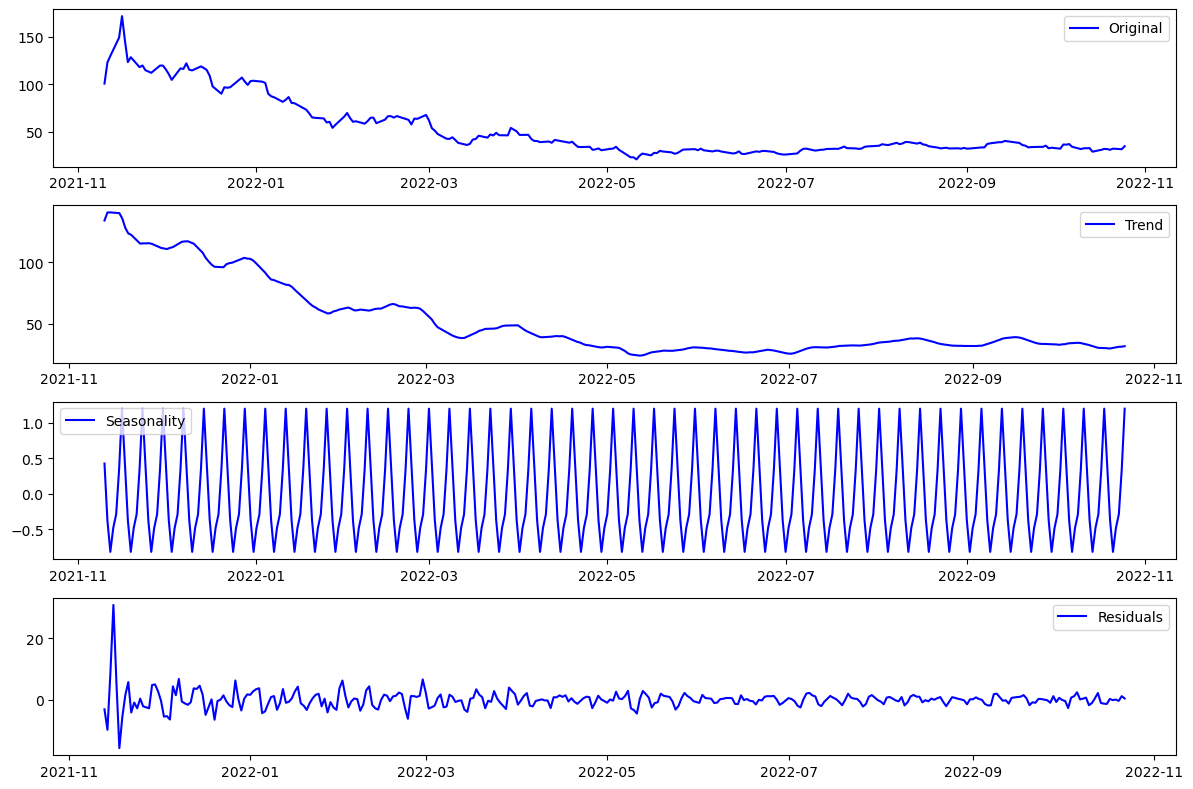

In [20]:
#Decomposing the closing data
decomposition = seasonal_decompose(riv_df['Close'].asfreq('d').ffill(), model = "additive")

# Gather the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal 
residual = decomposition.resid

# Plotting original, trend, seasonality, residuals
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(riv_df_close, label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')
plt.tight_layout()

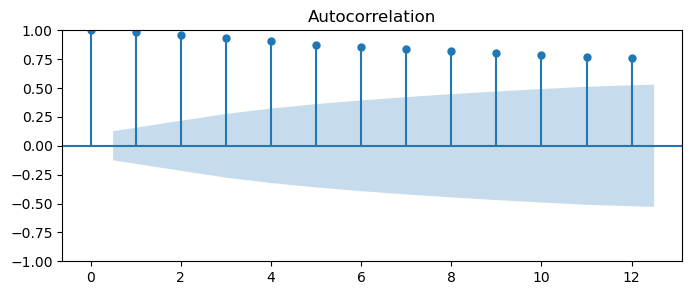

In [21]:
#Plotting the AutoCorrelation function
fig, ax = plt.subplots(figsize=(8,3))
plot_acf(riv_df['Close'],ax=ax, lags=12);

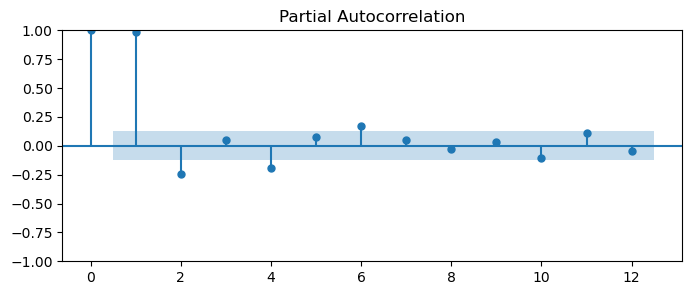

In [22]:
#Plotting the Partial AutoCorrelation Function
fig, ax = plt.subplots(figsize=(8,3))
plot_pacf(riv_df['Close'],ax=ax, lags=12, method='ywm');

## Removing the trend

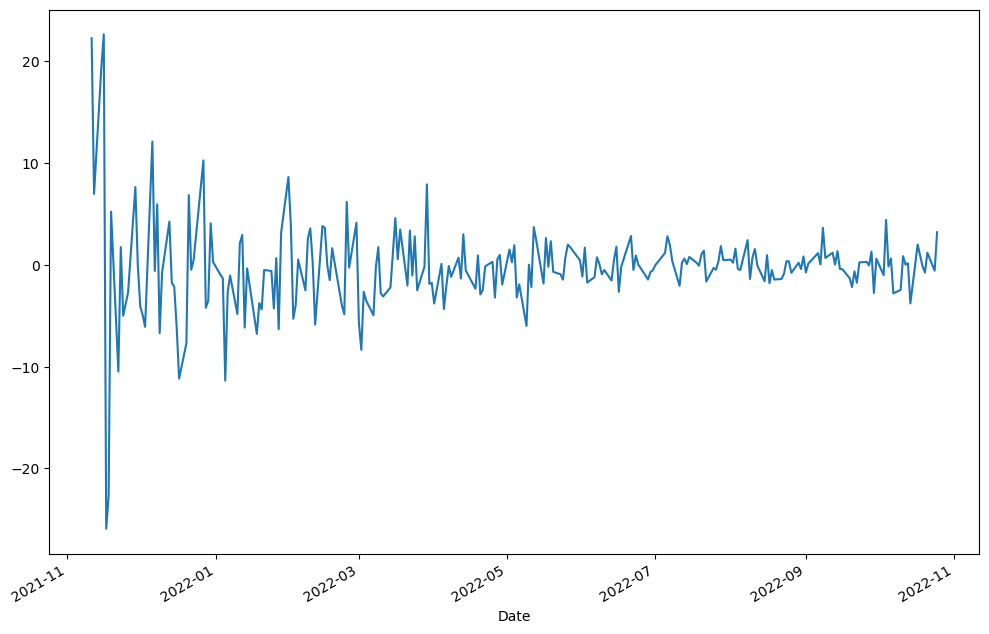

In [23]:
#Shifting the data 1 lag and subtracting it from original data
riv_df["close_diff"] = riv_df['Close'] - riv_df['Close'].shift(1)
riv_df["close_diff"].dropna().plot(figsize=(12, 8));

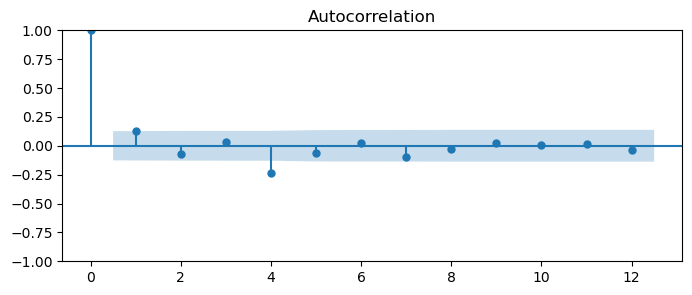

In [24]:
fig, ax = plt.subplots(figsize=(8,3))
plot_acf(riv_df["close_diff"].dropna(),ax=ax, lags=12);

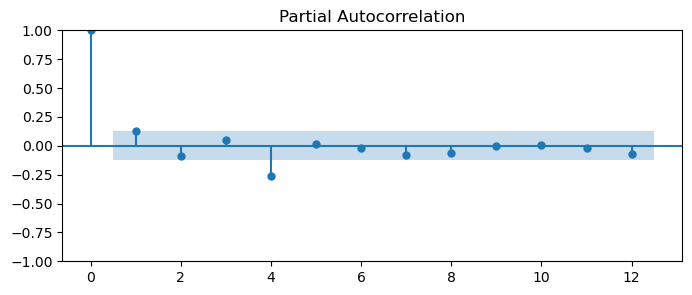

In [25]:
#Plotting the Partial AutoCorrelation Function
fig, ax = plt.subplots(figsize=(8,3))
plot_pacf(riv_df["close_diff"].dropna(),ax=ax, lags=12, method='ywm');

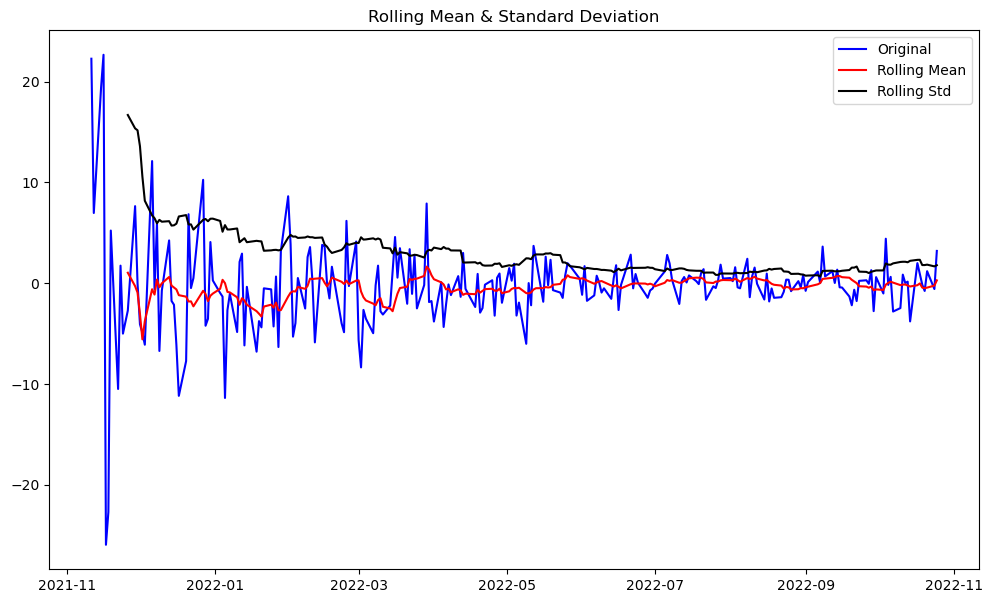

Results of the Dickey-Fuller Test
Test Statistics               -6.616987e+00
p-value                        6.171787e-09
No. of lags used               7.000000e+00
Number of observations used    2.320000e+02
critical value (1%)           -3.458855e+00
critical value (5%)           -2.874080e+00
critical value (10%)          -2.573453e+00
dtype: float64



Results of KPSS Test:
Test Statistic           0.108575
p-value                  0.100000
Lags Used                1.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


C:\Users\Jonathan\anaconda3\envs\time-series-env\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [26]:
#Checking tests on shifted data
test_trend(riv_df['close_diff'].dropna())

In [27]:
#Splitting data into train and test
train = riv_df['Close'].loc[:'2022-08-31']
test = riv_df['Close'].loc['2022-08-31':]

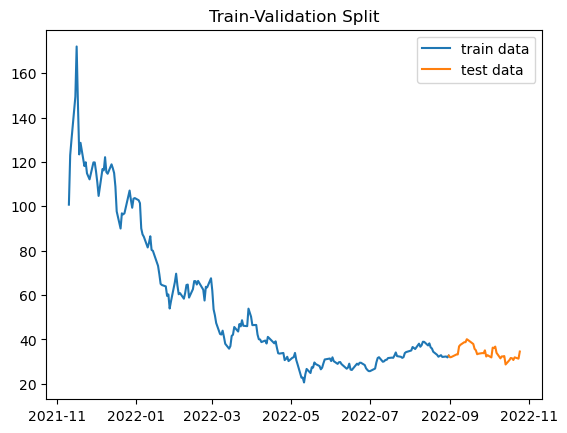

In [28]:
#Plotting train and split
fig, ax = plt.subplots()
ax.plot(train, label = 'train data')
ax.plot(test, label = 'test data')

ax.set_title("Train-Validation Split")

plt.legend();


# Modeling

## ARIMA model (I only)

In [29]:
I_model = ARIMA(train, order=(0,1,0)).fit()
I_model.predict(typ='levels')

C:\Users\Jonathan\anaconda3\envs\time-series-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Jonathan\anaconda3\envs\time-series-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Jonathan\anaconda3\envs\time-series-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Date
2021-11-10      0.000000
2021-11-11    100.730003
2021-11-12    122.989998
2021-11-15    129.949997
2021-11-16    149.360001
                 ...    
2022-08-25     32.560001
2022-08-26     32.900002
2022-08-29     32.110001
2022-08-30     32.310001
2022-08-31     31.889999
Name: predicted_mean, Length: 203, dtype: float64

In [30]:
I_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  203
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -608.333
Date:                Thu, 03 Nov 2022   AIC                           1218.666
Time:                        14:59:31   BIC                           1221.975
Sample:                             0   HQIC                          1220.005
                                - 203                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        24.1727      0.994     24.309      0.000      22.224      26.122
===================================================================================
Ljung-Box (L1) (Q):                   3.57   Jarque-Bera (JB):               814.15
Prob(Q):                              0.06   Prob(JB):                         0.00
Heteroskedasticity (H):               0.02   Skew:                             0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [31]:
I_model.aic

1218.6662882464193

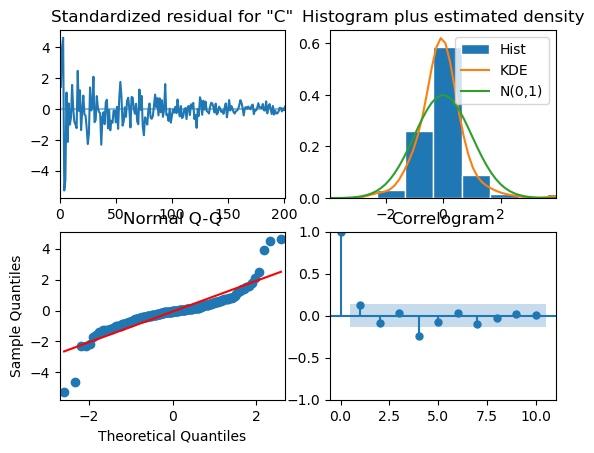

In [32]:
I_model.plot_diagnostics()
plt.show()

## ARIMA model (ARI)

In [33]:
ARI_model = ARIMA(train, order=(1,1,0)).fit()
ARI_model.predict(typ='levels')

C:\Users\Jonathan\anaconda3\envs\time-series-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Jonathan\anaconda3\envs\time-series-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Jonathan\anaconda3\envs\time-series-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Date
2021-11-10      0.000000
2021-11-11    100.730375
2021-11-12    126.381114
2021-11-15    131.010292
2021-11-16    152.316945
                 ...    
2022-08-25     32.613321
2022-08-26     32.951798
2022-08-29     31.989651
2022-08-30     32.340469
2022-08-31     31.826015
Name: predicted_mean, Length: 203, dtype: float64

In [34]:
ARI_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  203
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -606.193
Date:                Thu, 03 Nov 2022   AIC                           1216.386
Time:                        14:59:32   BIC                           1223.003
Sample:                             0   HQIC                          1219.063
                                - 203                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1523      0.025      6.120      0.000       0.104       0.201
sigma2        23.6631      0.965     24.514      0.000      21.771      25.555
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               902.98
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.02   Skew:                            -0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [35]:
ARI_model.aic

1216.3863518851754

In [36]:
print("Random Walk AIC: {}".format(I_model.aic))
print("ARI AIC: {}".format(ARI_model.aic))

Random Walk AIC: 1218.6662882464193
ARI AIC: 1216.3863518851754


In [37]:
y_hat_imodel = I_model.predict(typ='levels')
np.sqrt(mean_squared_error(train, y_hat_imodel))

8.604448480681418

In [38]:
y_hat_arimodel = ARI_model.predict(typ='levels')
np.sqrt(mean_squared_error(train, y_hat_arimodel))

8.578237568170834

In [39]:
ARI_model.arparams

array([0.15234126])

## AutoARIMA